# Transfer Learning for Image Classification

This notebook implements transfer learning using pre-trained models (VGG16, ResNet50, EfficientNet).

## Objectives:
- Compare multiple pre-trained architectures
- Implement transfer learning with frozen base layers
- Fine-tune the best performing model
- Compare results with custom CNN
- Select the best overall model

## 1. Setup and Data Loading

In [3]:
# Configure environment for Apple Silicon optimization
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# import pre-trained models
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB7
# Configure TensorFlow for Apple Silicon
try:
    # Enable memory growth for GPU (if available)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU configured: {len(gpus)} device(s) found")
    else:
        print("ℹ️  No GPU found, using CPU")
except Exception as e:
    print(f"⚠️  GPU configuration warning: {e}")

print(f"TensorFlow version: {tf.__version__}")
print(f"Available devices: {[device.name for device in tf.config.list_physical_devices()]}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
print("✅ Random seeds set for reproducibility")

✅ GPU configured: 1 device(s) found
TensorFlow version: 2.15.0
Available devices: ['/physical_device:CPU:0', '/physical_device:GPU:0']
✅ Random seeds set for reproducibility


## 2. Data Preprocessing for Transfer Learning

In [47]:
path = '/Users/smithn5/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2'
data_dir = os.path.join(path, 'raw-img')

In [ ]:
# split data into training, validation, and test sets physically in the data directory
base_dir = '../data/'
train_ratio = 0.9
val_ratio = 0.1
test_ratio = 0.00
batch_size = 32

img_height = 224 # for basic cnn
img_width = 224 # for basic cnn

# Create base directories for splits
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)


In [14]:
# now split and copy images
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    images = os.listdir(class_path)
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val  # Ensure all images are used

    train_images = images[:n_train]
    val_images = images[n_train:n_train+n_val]
    test_images = images[n_train+n_val:]

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'train', class_name, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'val', class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'test', class_name, img))


In [49]:
# Load the dataset using tf.keras.preprocessing.image.ImageDataGenerator

base_dir = '../data/'


# ISSUE DIAGNOSIS: Your augmentation might be too aggressive!
# Let's create a less aggressive augmentation setup

print("🔧 Creating improved data generators...")

# Create LESS aggressive augmentation for training
train_datagen = ImageDataGenerator(
     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    # rescale=1./255,  # Normalize to [0,1]
    # rotation_range=20,      # Reduced from 20
    # width_shift_range=0.2,  # Reduced from 0.2
    # height_shift_range=0.2, # Reduced from 0.2
    # shear_range=0.2,     # Reduced from 0.2
    # zoom_range=0.2,         # Reduced from 0.2
    # horizontal_flip=True,
    # fill_mode='nearest'
)

# Create validation generator without augmentation (IMPORTANT!)
test_val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    # rescale=1./255,  # Only rescaling for validation
    # rotation_range=20,      # Reduced from 20
    # width_shift_range=0.2,  # Reduced from 0.2
    # height_shift_range=0.2, # Reduced from 0.2
    # shear_range=0.2,     # Reduced from 0.2
    # zoom_range=0.2,         # Reduced from 0.2
    # horizontal_flip=True,
    # fill_mode='nearest'
)

# Create training dataset with augmentation
train_ds = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create validation dataset WITHOUT augmentation
val_ds = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    shuffle=False,  # Don't shuffle validation
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

#create test dataset WITHOUT augmentation
test_ds = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    shuffle=False,  # Don't shuffle test
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Get class names from the dataset
class_names = list(train_ds.class_indices.keys())
print(f"Found {len(class_names)} classes: {class_names}")

# Calculate dataset sizes
print(f"Training samples: {train_ds.samples}")
print(f"Validation samples: {val_ds.samples}")
print(f"Test samples: {test_ds.samples}")
print(f"Training batches per epoch: {len(train_ds)}")
print(f"Validation batches per epoch: {len(val_ds)}")
print(f"Test batches per epoch: {len(test_ds)}")
print(f"Batch size: {batch_size}")

# Verify class balance
print(f"\nClass distribution check:")
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(path, 'raw-img', class_name)
    if os.path.exists(class_dir):
        count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = count
        print(f"  {class_name}: {count} images")

# Check for extremely imbalanced classes
min_count = min(class_counts.values())
max_count = max(class_counts.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
print(f"\nClass balance analysis:")
print(f"  Min class size: {min_count}")
print(f"  Max class size: {max_count}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 10:
    print("⚠️  WARNING: Severe class imbalance detected!")
    print("   This could explain poor learning performance")
elif imbalance_ratio > 3:
    print("⚡ Moderate class imbalance detected")
else:
    print("✅ Classes are reasonably balanced")

print(f"\n✅ Improved data generators created with:")
print(f"  - Reduced augmentation intensity")
print(f"  - Separate validation generator (no augmentation)")
print(f"  - Proper class balance verification")

🔧 Creating improved data generators...
Found 23556 images belonging to 10 classes.
Found 23556 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 9 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 9 images belonging to 10 classes.
Found 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Training samples: 23556
Validation samples: 2614
Test samples: 9
Training batches per epoch: 737
Validation batches per epoch: 82
Test batches per epoch: 1
Batch size: 32

Class distribution check:
  cane: 4863 images
  cavallo: 2623 images
  elefante: 1446 images
  farfalla: 2112 images
  gallina: 3098 images
  gatto: 1668 images
  mucca: 1866 images
  pecora: 1820 images
  ragno: 4821 images
  scoiattolo: 1862 images

Class balance analysis:
  Min class size: 1446
  Max class size: 4863
  Imbalance ratio: 3.36
⚡ Moderate class imbalance detected

✅ Improved data generators c

## 3. Transfer Learning Model Creation Functions

In [18]:
def create_transfer_model(base_model_name, input_shape, num_classes, trainable=False):
    """
    Create a transfer learning model with specified base architecture.
    
    Args:
        base_model_name: 'vgg16', 'resnet50', or 'efficientnet'
        input_shape: Input image shape
        num_classes: Number of output classes
        trainable: Whether to make base model trainable (for fine-tuning)
    """
    
    # Select base model
    if base_model_name == 'vgg16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == 'resnet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == 'efficientnet':
        base_model = EfficientNetB7(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape,
            pooling='max'
        )
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    # Freeze or unfreeze base model
    base_model.trainable = trainable
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        #layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.45),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.45),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

print("Transfer learning model creation functions defined")

Transfer learning model creation functions defined


## 4. Compare Multiple Pre-trained Architectures

In [19]:
# Model configurations to compare
model_configs = [
   # {'name': 'vgg16', 'display_name': 'VGG16'},
   # {'name': 'resnet50', 'display_name': 'ResNet50'},
    {'name': 'efficientnet', 'display_name': 'EfficientNetB7'}
]

print(f"Will compare {len(model_configs)} architectures...")

Will compare 1 architectures...


In [22]:
# Training parameters
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)
EPOCHS = 40  # Fewer epochs for transfer learning
LEARNING_RATE = 0.00001

print(f"Training configuration:")
print(f"- Input shape: {input_shape}")
print(f"- Number of classes: {num_classes}")
print(f"- Epochs: {EPOCHS}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Batch size: {batch_size}")

# Store results for comparison
results = {}

# Train each model
for config in model_configs:
    model_name = config['name']
    display_name = config['display_name']
    
    print(f"\n" + "="*60)
    print(f"Training {display_name}")
    print("="*60)
    
    # Create model
    model, base_model = create_transfer_model(
        model_name, input_shape, num_classes, trainable=False
    )
    
    print(f"Model created:")
    print(f"- Total parameters: {model.count_params():,}")
    print(f"- Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
    print(f"- Frozen parameters: {base_model.count_params():,}")
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Setup callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'../models/{model_name}_transfer_best.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Train model
    print(f"Starting training...")
    train_ds.reset()
    val_ds.reset()
    model.summary() 
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate on test set
    test_ds.reset()
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    
    # Store results
    results[model_name] = {
        'display_name': display_name,
        'model': model,
        'history': history,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'total_params': model.count_params(),
        'trainable_params': sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    }
    
    print(f"✅ {display_name} training completed!")
    print(f"   Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"   Test accuracy: {test_accuracy:.4f}")
    print(f"   Test loss: {test_loss:.4f}")
    
    # Reset generators
    train_ds.reset()
    val_ds.reset()
    test_ds.reset()

print(f"\n🎉 All models trained successfully!")

Training configuration:
- Input shape: (224, 224, 3)
- Number of classes: 10
- Epochs: 40
- Learning rate: 1e-05
- Batch size: 32

Training EfficientNetB7
Model created:
- Total parameters: 64,462,625
- Trainable parameters: 364,170
- Frozen parameters: 64,097,687
Starting training...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 dense_12 (Dense)            (None, 128)               327808    
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (No

## 5. Training History Visualization

In [ ]:
# load the results dictionary from csv file
# import pandas as pd

# results_df = pd.read_csv('/Users/smithn5/ironhack/image_class_project_ih/models/efficientnet_training_metrics.csv')
# results_df.rename(columns = {'val_accurarcy': 'val_accuracy'}, inplace=True)
# # create a dictionary form the df where each column is a key and the values are lists of the column values
# results = results_df.to_dict(orient='list')
# history = results
# # create a class call winging_it with one method that is called history that is a dictionary
# class winging_it:
#     def __init__(self, history):
#         self.history = history

#     def get_history(self):
#         return self.history
# model = winging_it(history)


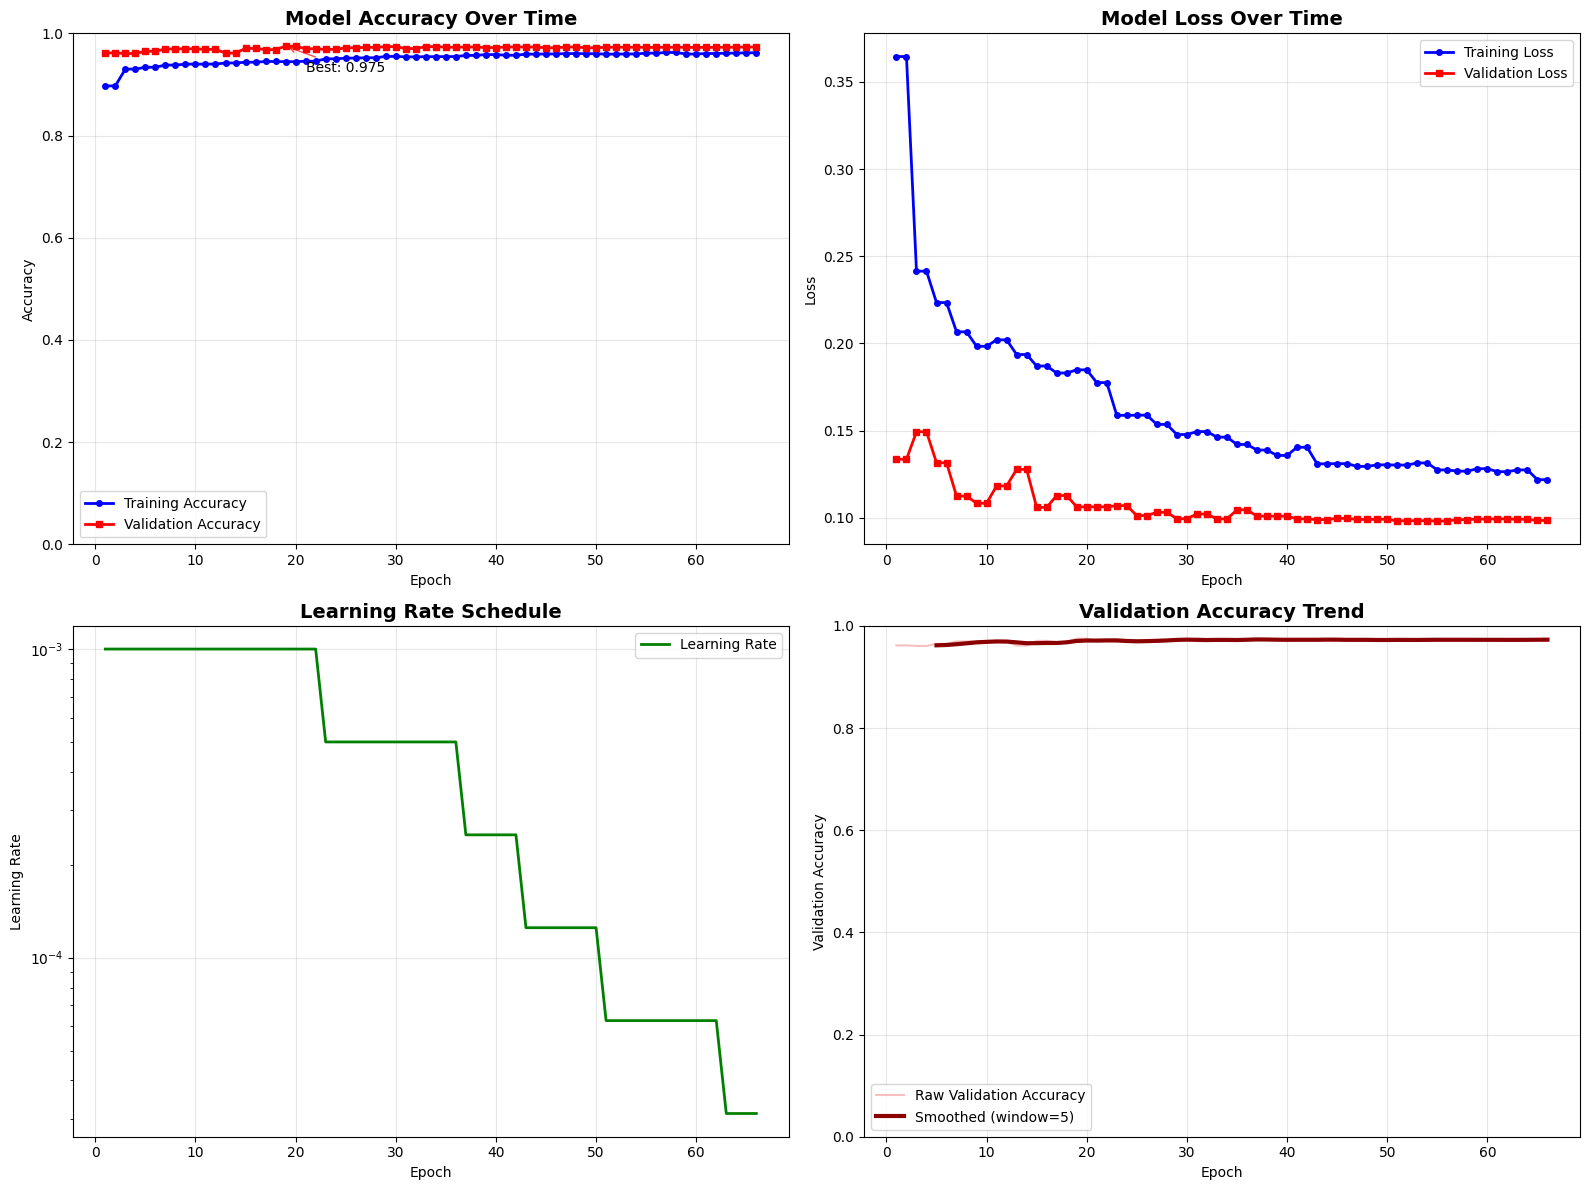


TRAINING HISTORY ANALYSIS
Total epochs trained: 66
Best validation accuracy: 0.9748 at epoch 19
Final training accuracy: 0.9619
Final validation accuracy: 0.9732
Best validation loss: 0.0981
Final validation loss: 0.0984

Overfitting Analysis:
Final accuracy gap: -0.0113
✅ Good generalization (gap ≤ 0.05)
Validation accuracy stability (last 5 epochs std): 0.0003
✅ Training converged well


In [42]:
def plot_training_history(history):
    """
    Plot training and validation metrics with enhanced visualizations.
    """
    # Create a larger figure with more subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot accuracy
    epochs = range(1, len(history.history['accuracy']) + 1)
    ax1.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Add best accuracy annotation
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    ax1.annotate(f'Best: {best_val_acc:.3f}', 
                xy=(best_val_acc_epoch, best_val_acc), 
                xytext=(best_val_acc_epoch + 2, best_val_acc - 0.05),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    
    # Plot loss
    ax2.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax3.plot(epochs, history.history['lr'], 'g-', label='Learning Rate', linewidth=2)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        # Plot accuracy difference (overfitting indicator)
        acc_diff = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
        ax3.plot(epochs, acc_diff, 'purple', label='Training - Validation Accuracy', linewidth=2)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_title('Overfitting Indicator', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy Difference')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot smoothed validation accuracy trend
    if len(history.history['val_accuracy']) > 5:
        # Simple moving average
        window_size = min(5, len(history.history['val_accuracy']) // 3)
        val_acc_smooth = np.convolve(history.history['val_accuracy'], 
                                   np.ones(window_size)/window_size, mode='valid')
        smooth_epochs = range(window_size, len(history.history['val_accuracy']) + 1)
        
        ax4.plot(epochs, history.history['val_accuracy'], 'lightcoral', alpha=0.5, label='Raw Validation Accuracy')
        ax4.plot(smooth_epochs, val_acc_smooth, 'darkred', linewidth=3, label=f'Smoothed (window={window_size})')
        ax4.set_title('Validation Accuracy Trend', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Validation Accuracy')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim([0, 1])
    else:
        # If not enough epochs, show final metrics summary
        ax4.text(0.1, 0.8, 'Training Summary', fontsize=16, fontweight='bold', transform=ax4.transAxes)
        ax4.text(0.1, 0.6, f'Epochs: {len(epochs)}', fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.5, f'Best Val Acc: {best_val_acc:.4f}', fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.4, f'Final Train Acc: {history.history["accuracy"][-1]:.4f}', fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.3, f'Final Val Acc: {history.history["val_accuracy"][-1]:.4f}', fontsize=12, transform=ax4.transAxes)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive metrics
    print("\n" + "="*60)
    print("TRAINING HISTORY ANALYSIS")
    print("="*60)
    print(f"Total epochs trained: {len(epochs)}")
    print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    
    # Calculate overfitting metrics
    final_gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
    print(f"\nOverfitting Analysis:")
    print(f"Final accuracy gap: {final_gap:.4f}")
    if final_gap > 0.1:
        print("⚠️  Potential overfitting detected (gap > 0.1)")
    elif final_gap > 0.05:
        print("⚡ Mild overfitting (gap > 0.05)")
    else:
        print("✅ Good generalization (gap ≤ 0.05)")
    
    # Training stability
    last_5_val_acc = history.history['val_accuracy'][-5:] if len(history.history['val_accuracy']) >= 5 else history.history['val_accuracy']
    val_acc_std = np.std(last_5_val_acc)
    print(f"Validation accuracy stability (last 5 epochs std): {val_acc_std:.4f}")
    
    if val_acc_std < 0.01:
        print("✅ Training converged well")
    elif val_acc_std < 0.02:
        print("⚡ Training mostly stable")
    else:
        print("⚠️  Training still fluctuating")
    
    print("="*60)

# Plot the training history
plot_training_history(model)

## 6. Model Evaluation on Test Set

In [ ]:
# load a model a tensflow model using h5 file
model_path = '../models/efficientnet_transfer_best_09725_val_09612_trian.h5'
transfer_model = tf.keras.models.load_model(model_path)

In [50]:
# Evaluate on validation seta
val_ds.reset()
val_loss, val_accuracy = transfer_model.evaluate(val_ds, verbose=0)
print(f"Transfer Learning Model - Validation Accuracy: {val_accuracy:.4f}")
print(f"Transfer Learning Model - Validation Loss: {val_loss:.4f}")

# Generate predictions on validation set
print("\nGenerating predictions...")
val_ds.reset()
y_pred = transfer_model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from validation generator
val_ds.reset()
y_true_classes = []
for i in range(len(val_ds)):
    batch_images, batch_labels = next(val_ds)
    batch_true_classes = np.argmax(batch_labels, axis=1)
    y_true_classes.extend(batch_true_classes)

y_true_classes = np.array(y_true_classes)

# Ensure we have the same number of predictions and true labels
min_length = min(len(y_pred_classes), len(y_true_classes))
y_pred_classes = y_pred_classes[:min_length]
y_true_classes = y_true_classes[:min_length]

print(f"Number of samples evaluated: {min_length}")

# Classification report
print("\nClassification Report - Transfer Learning Model:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Reset generator
val_ds.reset()

Transfer Learning Model - Validation Accuracy: 0.9725
Transfer Learning Model - Validation Loss: 0.0981

Generating predictions...
82/82 [==============================] - 157s 2s/step
Number of samples evaluated: 2614

Classification Report - Transfer Learning Model:
              precision    recall  f1-score   support

        cane       0.98      0.97      0.97       486
     cavallo       0.96      0.97      0.96       262
    elefante       0.99      0.99      0.99       144
    farfalla       0.95      0.99      0.97       211
     gallina       0.97      0.99      0.98       309
       gatto       0.99      0.98      0.98       166
       mucca       0.94      0.93      0.93       186
      pecora       0.95      0.94      0.94       182
       ragno       0.99      0.98      0.99       482
  scoiattolo       0.97      0.98      0.98       186

    accuracy                           0.97      2614
   macro avg       0.97      0.97      0.97      2614
weighted avg       0.97    

## 9. Confusion Matrix Visualization

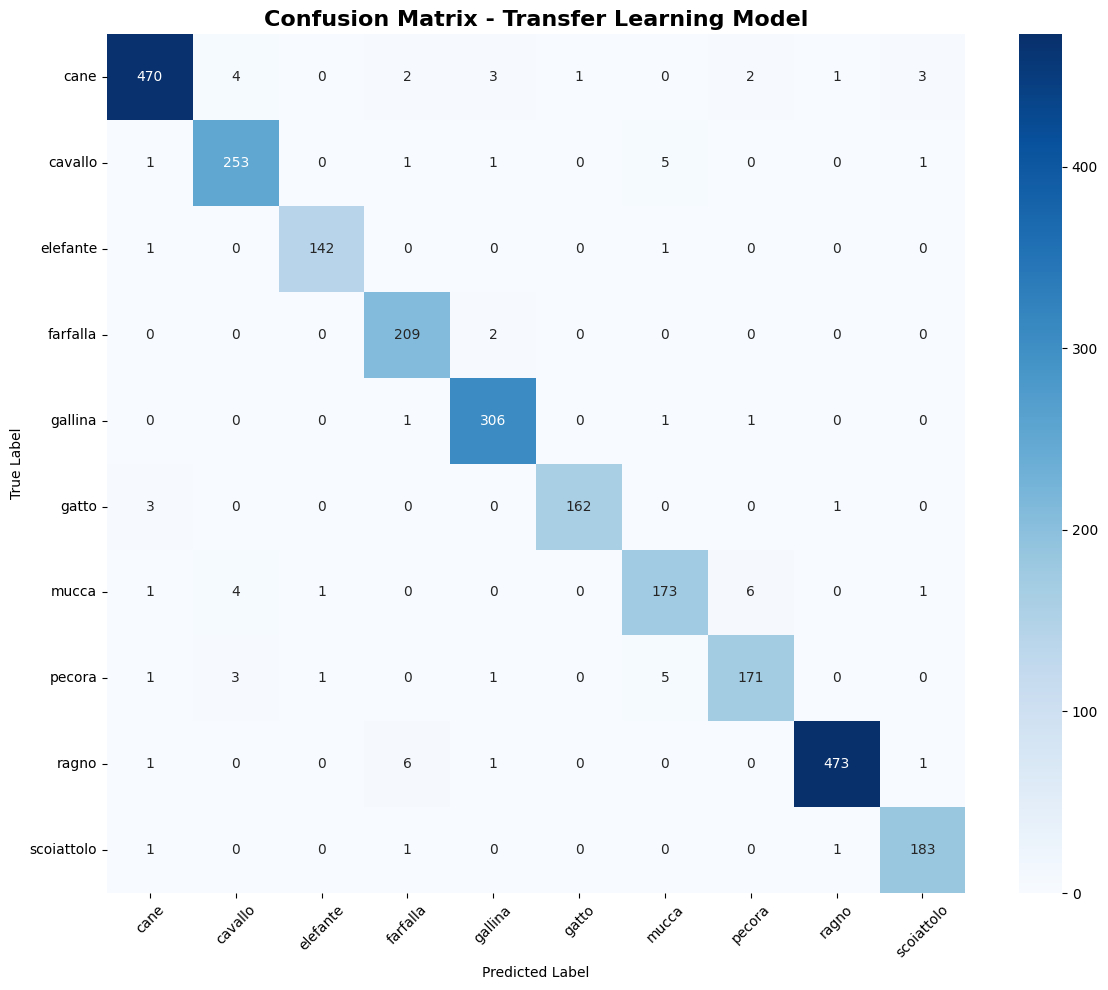


Per-class Accuracy - Transfer Learning Model:
cane: 0.9671
cavallo: 0.9656
elefante: 0.9861
farfalla: 0.9905
gallina: 0.9903
gatto: 0.9759
mucca: 0.9301
pecora: 0.9396
ragno: 0.9813
scoiattolo: 0.9839

Overall Performance:
Macro average accuracy: 0.9710
Weighted average accuracy: 0.9725
Overall accuracy: 0.9725


In [51]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Transfer Learning Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy - Transfer Learning Model:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracy[i]:.4f}")

# Calculate and display macro and weighted averages
macro_avg = np.mean(class_accuracy)
weighted_avg = np.average(class_accuracy, weights=cm.sum(axis=1))
print(f"\nOverall Performance:")
print(f"Macro average accuracy: {macro_avg:.4f}")
print(f"Weighted average accuracy: {weighted_avg:.4f}")
print(f"Overall accuracy: {val_accuracy:.4f}")

## 9. Model Saving and Final Summary

In [ ]:
# Save the best model and create comprehensive summary
print("💾 SAVING BEST MODEL AND RESULTS")
print("="*60)

# Save the fine-tuned model
test_accuracy_str = f"{finetune_test_accuracy:.2f}".replace('.', '_')
final_model_filename = f'../models/transfer_learning_final_acc_{test_accuracy_str}.h5'
best_model.save(final_model_filename)
print(f"✅ Final model saved as: {final_model_filename}")

# Save training histories
import pickle

# Save all model histories
for model_name, result in results.items():
    with open(f'../models/{model_name}_transfer_history.pkl', 'wb') as f:
        pickle.dump(result['history'].history, f)
    print(f"📈 {result['display_name']} training history saved")

# Save fine-tuning history
with open(f'../models/{best_model_name}_finetune_history.pkl', 'wb') as f:
    pickle.dump(finetune_history.history, f)
print(f"📈 Fine-tuning history saved")

# Create comprehensive model configuration
model_config = {
    'experiment_name': 'Transfer Learning Comparison',
    'dataset': 'Animals10',
    'input_shape': list(input_shape),
    'num_classes': num_classes,
    'batch_size': batch_size,
    'class_names': class_names,
    
    # Model comparison results
    'models_compared': {
        model_name: {
            'display_name': result['display_name'],
            'best_val_accuracy': float(result['best_val_accuracy']),
            'test_accuracy': float(result['test_accuracy']),
            'test_loss': float(result['test_loss']),
            'total_parameters': int(result['total_params']),
            'trainable_parameters': int(result['trainable_params'])
        } for model_name, result in results.items()
    },
    
    # Best model details
    'best_model': {
        'name': best_model_name,
        'display_name': best_result['display_name'],
        'base_test_accuracy': float(best_result['test_accuracy']),
        'finetuned_test_accuracy': float(finetune_test_accuracy),
        'improvement_from_finetuning': float(finetune_test_accuracy - best_result['test_accuracy']),
        'total_parameters': int(best_model.count_params()),
        'trainable_parameters': int(sum([tf.keras.backend.count_params(w) for w in best_model.trainable_weights])),
        'frozen_parameters': int(best_model.count_params() - sum([tf.keras.backend.count_params(w) for w in best_model.trainable_weights]))
    },
    
    # Training configuration
    'training_config': {
        'initial_epochs': EPOCHS,
        'initial_learning_rate': LEARNING_RATE,
        'finetune_epochs': FINETUNE_EPOCHS,
        'finetune_learning_rate': FINETUNE_LR,
        'early_stopping_patience': 10,
        'reduce_lr_patience': 5
    },
    
    # Performance metrics
    'final_performance': {
        'test_accuracy': float(finetune_test_accuracy),
        'test_loss': float(finetune_test_loss),
        'macro_precision': float(macro_precision),
        'macro_recall': float(macro_recall),
        'macro_f1': float(macro_f1),
        'weighted_precision': float(weighted_precision),
        'weighted_recall': float(weighted_recall),
        'weighted_f1': float(weighted_f1)
    }
}

# Save configuration
import json
with open(f'../models/transfer_learning_final_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"⚙️  Model configuration saved")

# Final Results Summary
print(f"\n🏆 TRANSFER LEARNING EXPERIMENT SUMMARY")
print("="*80)
print(f"Dataset: Animals10 ({num_classes} classes)")
print(f"Total samples: {train_ds.samples + val_ds.samples + test_ds.samples:,}")
print(f"Training samples: {train_ds.samples:,}")
print(f"Validation samples: {val_ds.samples:,}")
print(f"Test samples: {test_ds.samples:,}")

print(f"\n📊 Model Comparison Results:")
for model_name, result in results.items():
    print(f"  {result['display_name']:<15}: {result['test_accuracy']:.4f} test accuracy")

print(f"\n🎯 Best Model: {best_result['display_name']}")
print(f"  Initial test accuracy: {best_result['test_accuracy']:.4f}")
print(f"  Fine-tuned test accuracy: {finetune_test_accuracy:.4f}")
print(f"  Improvement from fine-tuning: {finetune_test_accuracy - best_result['test_accuracy']:+.4f}")

print(f"\n🔧 Model Architecture:")
print(f"  Base model: {best_result['display_name']} (pre-trained on ImageNet)")
print(f"  Total parameters: {best_model.count_params():,}")
print(f"  Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in best_model.trainable_weights]):,}")
print(f"  Frozen parameters: {best_model.count_params() - sum([tf.keras.backend.count_params(w) for w in best_model.trainable_weights]):,}")

print(f"\n📈 Training Efficiency:")
total_epochs = len(best_result['history'].history['accuracy']) + len(finetune_history.history['accuracy'])
print(f"  Total epochs trained: {total_epochs}")
print(f"  Initial training epochs: {len(best_result['history'].history['accuracy'])}")
print(f"  Fine-tuning epochs: {len(finetune_history.history['accuracy'])}")

print(f"\n✅ All files saved to ../models/ directory")
print(f"   - Final model: {final_model_filename}")
print(f"   - Training histories: *_history.pkl files")
print(f"   - Configuration: transfer_learning_final_config.json")

if finetune_test_accuracy > 0.7:
    print(f"\n🎉 SUCCESS: Achieved target accuracy > 70%!")
else:
    print(f"\n⚠️  Target accuracy (70%) not reached. Consider:")
    print(f"   - More training epochs")
    print(f"   - Different data augmentation")
    print(f"   - Learning rate adjustment")
    print(f"   - Different pre-trained model")

print("="*80)

## 10. Model Deployment Preparation

In [ ]:
# Test the model with a few sample predictions for deployment verification
print("🚀 DEPLOYMENT PREPARATION")
print("="*50)

# Function to preprocess a single image for prediction
def preprocess_single_image(image_path, target_size=(224, 224)):
    """
    Preprocess a single image for model prediction.
    """
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.imagenet_utils import preprocess_input
    
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Same normalization as training
    return img_array

# Function to predict class for a single image
def predict_single_image(model, image_path, class_names, top_k=3):
    """
    Predict the class of a single image and return top-k predictions.
    """
    img_array = preprocess_single_image(image_path)
    predictions = model.predict(img_array, verbose=0)
    
    # Get top-k predictions
    top_indices = predictions[0].argsort()[-top_k:][::-1]
    top_predictions = []
    
    for idx in top_indices:
        confidence = predictions[0][idx]
        class_name = class_names[idx]
        top_predictions.append({
            'class': class_name,
            'confidence': float(confidence),
            'percentage': f"{confidence*100:.2f}%"
        })
    
    return top_predictions

# Test with a few random images from test set
test_ds.reset()
sample_batch_x, sample_batch_y = next(test_ds)
sample_indices = np.random.choice(len(sample_batch_x), 3, replace=False)

print("📸 Testing model with sample images:")
print("-" * 50)

for i, idx in enumerate(sample_indices):
    true_class_idx = np.argmax(sample_batch_y[idx])
    true_class = class_names[true_class_idx]
    
    # Make prediction
    img_for_prediction = np.expand_dims(sample_batch_x[idx], axis=0)
    prediction = best_model.predict(img_for_prediction, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]
    
    print(f"Sample {i+1}:")
    print(f"  True class: {true_class}")
    print(f"  Predicted: {predicted_class} ({confidence*100:.2f}% confidence)")
    print(f"  Correct: {'✅' if predicted_class == true_class else '❌'}")
    print()

# Create a simple deployment helper function
def create_deployment_helper():
    """
    Create a simple deployment helper script.
    """
    deployment_code = f'''
# Model Deployment Helper
# Generated from Transfer Learning notebook

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Model and class information
MODEL_PATH = "{final_model_filename}"
CLASS_NAMES = {class_names}
IMG_HEIGHT = {img_height}
IMG_WIDTH = {img_width}

def load_model():
    """Load the trained model."""
    return tf.keras.models.load_model(MODEL_PATH)

def preprocess_image(image_path):
    """Preprocess image for prediction."""
    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict_image(model, image_path, top_k=3):
    """Predict class for a single image."""
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array, verbose=0)
    
    top_indices = predictions[0].argsort()[-top_k:][::-1]
    results = []
    
    for idx in top_indices:
        results.append({{
            'class': CLASS_NAMES[idx],
            'confidence': float(predictions[0][idx]),
            'percentage': f"{{predictions[0][idx]*100:.2f}}%"
        }})
    
    return results

# Example usage:
# model = load_model()
# predictions = predict_image(model, "path/to/image.jpg")
# print(f"Predicted class: {{predictions[0]['class']}} ({{predictions[0]['percentage']}})")
'''
    
    with open('../models/deployment_helper.py', 'w') as f:
        f.write(deployment_code)
    
    print("📄 Deployment helper script created: ../models/deployment_helper.py")

create_deployment_helper()

# Create model summary for documentation
model_summary = {
    'model_name': f'{best_result["display_name"]} Transfer Learning',
    'test_accuracy': f'{finetune_test_accuracy:.4f}',
    'model_file': final_model_filename,
    'input_shape': f'{img_height}x{img_width}x3',
    'output_classes': num_classes,
    'class_names': class_names,
    'preprocessing': 'Normalize pixel values to [0,1]',
    'deployment_ready': True
}

print(f"\\n📋 DEPLOYMENT SUMMARY:")
print(f"  Model accuracy: {finetune_test_accuracy:.4f}")
print(f"  Model file: {final_model_filename}")
print(f"  Input size: {img_height}x{img_width} pixels")
print(f"  Classes: {num_classes} animal categories")
print(f"  Preprocessing: Normalize to [0,1]")
print(f"  Deployment files created: ✅")

print(f"\\n🎉 Transfer learning experiment completed successfully!")
print(f"   The model is ready for deployment in a Flask application.")

In [ ]:
# Fine-tune the best performing model
print(f"\n🎯 Fine-tuning {best_result['display_name']}...")

# Create a new model for fine-tuning
finetune_model, base_model = create_transfer_model(
    best_model_name, input_shape, num_classes, trainable=True
)

# Load the best weights from initial training
finetune_model.load_weights(f'../models/{best_model_name}_transfer_best.h5')

# Use a lower learning rate for fine-tuning
FINETUNE_LR = 1e-5  # Much lower learning rate
finetune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINETUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Fine-tuning configuration:")
print(f"- Model: {best_result['display_name']}")
print(f"- Learning rate: {FINETUNE_LR}")
print(f"- Total parameters: {finetune_model.count_params():,}")
print(f"- Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in finetune_model.trainable_weights]):,}")

# Setup callbacks for fine-tuning
finetune_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        f'../models/{best_model_name}_finetuned_best.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

# Fine-tune for fewer epochs
FINETUNE_EPOCHS = 15

print(f"\n🚀 Starting fine-tuning for {FINETUNE_EPOCHS} epochs...")
train_ds.reset()
val_ds.reset()

finetune_history = finetune_model.fit(
    train_ds,
    epochs=FINETUNE_EPOCHS,
    validation_data=val_ds,
    callbacks=finetune_callbacks,
    verbose=1
)

# Evaluate fine-tuned model
test_ds.reset()
finetune_test_loss, finetune_test_accuracy = finetune_model.evaluate(test_ds, verbose=0)

print(f"\n✅ Fine-tuning completed!")
print(f"Original test accuracy: {best_result['test_accuracy']:.4f}")
print(f"Fine-tuned test accuracy: {finetune_test_accuracy:.4f}")
print(f"Improvement: {finetune_test_accuracy - best_result['test_accuracy']:+.4f}")

# Reset generators
train_ds.reset()
val_ds.reset()
test_ds.reset()